In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv(r"lsd_reports.csv")
df.head()

,title,substance,age,weight,gender,report_text
0,Tribute to My Shaman,LSD,Age at time of experience: 24,175 lb,Male,DOSE:T+ 0:001 hitLSDT+ 1:3810 mgoralPharms - D...
1,Amazing: Not A Good Enough Word,LSD,Age at time of experience: 19,135 lb,Male,DOSE:T+ 0:00100 mginsufflatedKetamineT+ 8:352 ...
2,Leaping Off the Edge of Forever,LSD,Age at time of experience: Not Given,165 lb,Male,DOSE:oralOpium(tar / resin)3 dropsoralLSD(liqu...
3,A Psychedelic Way of Life,LSD,Age at time of experience: Not Given,135 lb,Male,DOSE:3 hitsoralLSD(liquid)BODY WEIGHT:135 lbno...
4,Took Lower Doses of Each,LSD,Age at time of experience: 30,90 kg,Male,DOSE:T+ 0:00oralLSDT+ 3:450.5 tabletsoralMDMAB...


In [2]:
import re
import contractions

def clean_psychedelic_report(text):
    """Initial structure cleanup: remove BODY WEIGHT... and trailing metadata"""
    if pd.isna(text):
        return ""

    text = text.replace('\xa0', ' ').replace('\n', ' ').strip()

    # Remove everything before BODY WEIGHT
    text = re.sub(r"^.*?BODY WEIGHT:\s*\d+\s*\w+\s*", "", text)

    # Remove everything after Exp Year
    end_match = re.search(r"Exp Year: \d{4}ExpID:", text)
    if end_match:
        text = text[:end_match.start()]

    return re.sub(r'\s{2,}', ' ', text).strip()

def remove_duplicates(text):
    """Remove repeated sentences"""
    sentences = text.split('. ')
    seen = set()
    unique_sentences = []
    for s in sentences:
        s_clean = s.strip()
        if s_clean and s_clean not in seen:
            seen.add(s_clean)
            unique_sentences.append(s_clean)
    return '. '.join(unique_sentences)

def final_nlp_clean(text):
    """Final normalization and cleaning for NLP"""
    if pd.isna(text):
        return ""

    # Contractions
    text = contractions.fix(text)

    # Remove parentheticals
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    
    # Replace em/en dash, ellipsis, and double hyphen with comma
    text = text.replace('—', ',').replace('–', ',').replace('…', ',').replace('--', ',')

    # Standardize repeated punctuation
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    # Add spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)

    # Separate camelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Collapse spaces and lowercase
    text = re.sub(r'\s{2,}', ' ', text).lower()

    return text.strip()

In [3]:
df['report_text'] = df['report_text'].apply(clean_psychedelic_report)
df['report_text'] = df['report_text'].apply(remove_duplicates)
df['report_text'] = df['report_text'].apply(final_nlp_clean)

In [4]:
def extract_age(text):
    """Extract age or return 'Not Given'."""
    if pd.isna(text):
        return "Not Given"
    match = re.search(r'Age at time of experience:\s*(\d+|Not Given)', text, re.IGNORECASE)
    return match.group(1) if match else "Not Given"

def extract_weight(text):
    """Extract weight in kg from lb, kg, or stone."""
    if pd.isna(text):
        return np.nan
    match = re.search(r'(\d+)\s*(lb|kg|st)', text.lower())
    if match:
        val, unit = int(match.group(1)), match.group(2)
        if unit == 'kg':
            return val
        elif unit == 'lb':
            return round(val * 0.453592)  # convert lb to kg
        elif unit == 'st':
            return round(val * 6.35029)   # convert stone to kg
    return np.nan

# Apply to columns
df['age'] = df['age'].apply(extract_age)
df['weight'] = df['weight'].apply(extract_weight)

In [5]:
df.tail()

,title,substance,age,weight,gender,report_text
1008,Gratuitous Grace,LSD,Not Given,54.0,Male,following is a report of an intense experience...
1009,Unexpected and Exhausting,LSD,Not Given,55.0,Female,most frightening thing about taking lsd and ke...
1010,Too Many Sounds,LSD,Not Given,76.0,Male,here is some background info about myself. i a...
1011,Floating with the Clouds,LSD,17,88.0,Male,never expected my night to be anything like it...
1012,A Day With Albert's Child,LSD,18,70.0,Male,am a male 18 years old of average body weight....


In [6]:
df['report_text'][5]

"dose:repeatedsmoked cannabis1. 5 hitssublingual lsd0. 5 tabletsoral mdmarepeatedsmoked cannabis before i get started with this trip-report, let me provide you with some information about my drug intake prior to this experience. i would smoked weed countless times before this trip, and had taken mdma more times than i could count, too. i would tripped on acid 3 times in total, though the third time i got shitty tabs so i do not really like to count that as a real trip. i would taken n-bombe once. the day of the trip began, and i had not slept a wink the night before. so the entire day i was very tired and groggy, with only marijuana to assist me in staying awake and alert. me and a friend, we will call him b, went and picked up three tabs between us as we were on our way to a house party with a number of our other friends. we arrived at the house a little early as we knew the person who was hosting the party and she allowed us to sit in her living area and watch tv while we waited for 

In [7]:
df['report_text'][10]

"and my friend, grown bored of marijuana and cheap booze, had decided that we wanted to try something different. a more involved/complex headchange. something a tad bit more interesting. i had not known much about acid at the time except that it was expensive and very hard to find and it had really never crossed my mind to take it. my friend who i mentioned before had told me that he had taken acid before and that it would be almost exactly what we were looking for in terms of a 'different' high. i spent at least a month asking around and finally got ahold of somebody who knew what they were talking about. i ordered a day in advance and recieved 2 tabs. for the price i had paid, i told myself the inevitable 'it better be good'. the next day after school, i went to g's house at about 4 of clock. we had planned to trip for the rest of the day/night. i unveiled the tabs under g's blacklight and they glowed a brilliant blue. he had previously informed me that what i bought might not have b

In [8]:
def fix_common_mojibake(text):
    if not isinstance(text, str):
        return text

    replacements = {
        'â€™': "'",
        'â€œ': '"',
        'â€': '"',
        'â€“': '-', 
        'â€”': '-', 
        'â€¦': '...', 
        'Ã©': 'é',
        'Ã¨': 'è',
        'Ã¢': 'â',
        'Ãª': 'ê',
        'Ã´': 'ô',
        'Ã': 'à',
        'Â': '',  # sometimes appears before currency symbols
    }

    for wrong, right in replacements.items():
        text = text.replace(wrong, right)

    return text

df['report_text'] = df['report_text'].apply(fix_common_mojibake)

In [9]:
import re

def fix_leading_contractions_lower(text):
    if pd.isna(text):
        return ""

    # Beginning of text
    text = re.sub(r"^['‘’]m\b", "i am", text)
    text = re.sub(r"^['‘’]ve\b", "i have", text)
    text = re.sub(r"^['‘’]d\b", "i would", text)
    text = re.sub(r"^['‘’]ll\b", "i will", text)

    return text

df['report_text'] = df['report_text'].apply(fix_leading_contractions_lower)

In [10]:
df['report_text'][10]

"and my friend, grown bored of marijuana and cheap booze, had decided that we wanted to try something different. a more involved/complex headchange. something a tad bit more interesting. i had not known much about acid at the time except that it was expensive and very hard to find and it had really never crossed my mind to take it. my friend who i mentioned before had told me that he had taken acid before and that it would be almost exactly what we were looking for in terms of a 'different' high. i spent at least a month asking around and finally got ahold of somebody who knew what they were talking about. i ordered a day in advance and recieved 2 tabs. for the price i had paid, i told myself the inevitable 'it better be good'. the next day after school, i went to g's house at about 4 of clock. we had planned to trip for the rest of the day/night. i unveiled the tabs under g's blacklight and they glowed a brilliant blue. he had previously informed me that what i bought might not have b

In [11]:
# Define a word count function
def count_words(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

# Apply word count to each report
df['word_count'] = df['report_text'].apply(count_words)

In [12]:
# Count reports <500 and >2500 words
less_than_500 = (df['word_count'] < 500).sum()
greater_than_2000 = (df['word_count'] > 2500).sum()

print(f"Reports with fewer than 500 words: {less_than_500}")
print(f"Reports with more than 2500 words: {greater_than_2000}")

Reports with fewer than 500 words: 102
Reports with more than 2500 words: 74


In [13]:
df.head()

,title,substance,age,weight,gender,report_text,word_count
0,Tribute to My Shaman,LSD,24,79.0,Male,a year ago a very good friend of a friend intr...,1962
1,Amazing: Not A Good Enough Word,LSD,19,61.0,Male,for a while i have had a sort of “to do” list ...,2263
2,Leaping Off the Edge of Forever,LSD,Not Given,75.0,Male,info: heavily experienced psychonaut at the ag...,1974
3,A Psychedelic Way of Life,LSD,Not Given,61.0,Male,long ago i was handed a couple of sugar cubes ...,262
4,Took Lower Doses of Each,LSD,30,90.0,Male,time candyflipping i'll try to be a bit more t...,1914


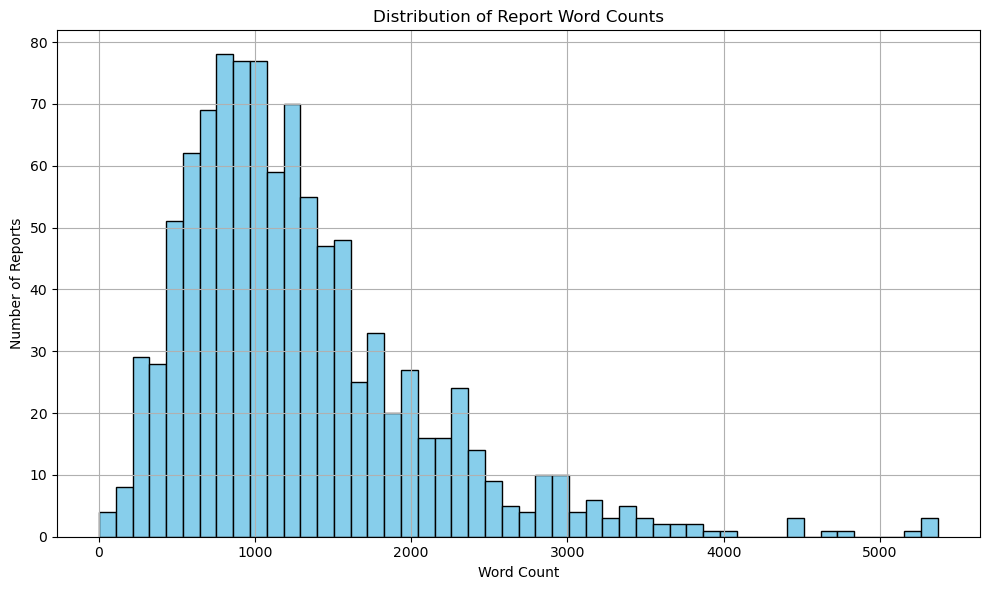

In [14]:
import matplotlib.pyplot as plt

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Report Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Reports')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df.shape

(1013, 7)

864 within 500 to 2500, we will take 800

In [16]:
# Count reports with fewer than 700 and 800 words
less_than_700 = (df['word_count'] < 700).sum()
less_than_800 = (df['word_count'] < 800).sum()

print(f"Reports with fewer than 700 words: {less_than_700}")
print(f"Reports with fewer than 800 words: {less_than_800}")

Reports with fewer than 700 words: 216
Reports with fewer than 800 words: 289


In [17]:
# Step 1: Filter reports between 500 and 2500 words
filtered_df = df[(df['word_count'] > 500) & (df['word_count'] < 2500)]

# Step 2: Randomly sample 800 reports from the filtered DataFrame
sampled_df = filtered_df.sample(n=800, random_state=42)  # random_state ensures reproducibility

# Step 3: Save to CSV
sampled_df.to_csv("lsd_800_reports.csv", index=False)

print(f"Filtered {len(filtered_df)} reports, saved 800 to 'lsd_800_reports.csv'")

Filtered 837 reports, saved 800 to 'final_800_reports.csv'
